In [15]:
import numpy as np

class MarketState:
    def __init__(self, equity=100.0, commodity=80.0, fx=50.0, risk=20.0):
        self.equity = equity
        self.commodity = commodity
        self.fx = fx
        self.risk = risk


def smooth(prev, current, alpha):
    return alpha * current + (1.0 - alpha) * prev


def filter_estimate(estimate, measurement, gain):
    return estimate + gain * (measurement - estimate)


def evolve(prev_state):
    next_state = MarketState(
        equity    = prev_state.equity    + np.random.normal(0, 0.5),
        commodity = prev_state.commodity + np.random.normal(0, 0.3),
        fx        = prev_state.fx        + np.random.normal(0, 0.2),
        risk      = prev_state.risk      + np.random.normal(0, 0.4)
    )
    return next_state


def compute_index(state):
    w_equity    = 0.40
    w_commodity = 0.25
    w_fx        = 0.20
    w_risk      = 0.15

    return (
        w_equity    * state.equity +
        w_commodity * state.commodity +
        w_fx        * state.fx -
        w_risk      * state.risk      # inverse relation
    )


def main():
    np.random.seed(42)

    state = MarketState()
    index_estimate = compute_index(state)

    alpha = 0.2   # smoothing factor
    gain  = 0.15  # filter gain

    print("Simulated Asia Trade Index")
    print("--------------------------")

    for t in range(1, 51):
        state = evolve(state)

        raw_index = compute_index(state)

        smoothed = smooth(index_estimate, raw_index, alpha)

        index_estimate = filter_estimate(index_estimate, smoothed, gain)

        print(f"Tick {t:02d} | Raw: {raw_index:.4f} | Estimate: {index_estimate:.4f}")


if __name__ == "__main__":
    main()

Simulated Asia Trade Index
--------------------------
Tick 01 | Raw: 67.0235 | Estimate: 67.0007
Tick 02 | Raw: 66.9762 | Estimate: 67.0000
Tick 03 | Raw: 66.9324 | Estimate: 66.9979
Tick 04 | Raw: 66.8021 | Estimate: 66.9921
Tick 05 | Raw: 66.6715 | Estimate: 66.9825
Tick 06 | Raw: 67.0359 | Estimate: 66.9841
Tick 07 | Raw: 66.8667 | Estimate: 66.9805
Tick 08 | Raw: 66.5895 | Estimate: 66.9688
Tick 09 | Raw: 66.6136 | Estimate: 66.9581
Tick 10 | Raw: 66.4435 | Estimate: 66.9427
Tick 11 | Raw: 66.6175 | Estimate: 66.9330
Tick 12 | Raw: 66.1859 | Estimate: 66.9105
Tick 13 | Raw: 66.1585 | Estimate: 66.8880
Tick 14 | Raw: 66.0544 | Estimate: 66.8630
Tick 15 | Raw: 65.8181 | Estimate: 66.8316
Tick 16 | Raw: 65.7358 | Estimate: 66.7988
Tick 17 | Raw: 65.9369 | Estimate: 66.7729
Tick 18 | Raw: 65.8831 | Estimate: 66.7462
Tick 19 | Raw: 65.8391 | Estimate: 66.7190
Tick 20 | Raw: 65.9570 | Estimate: 66.6961
Tick 21 | Raw: 66.0301 | Estimate: 66.6762
Tick 22 | Raw: 65.8477 | Estimate: 66.6513


Tick 000 | Regime: RISK_ON  | Raw:   67.453 | Est:   67.010 | Buy 0.33 Hold 0.33 Sell 0.33


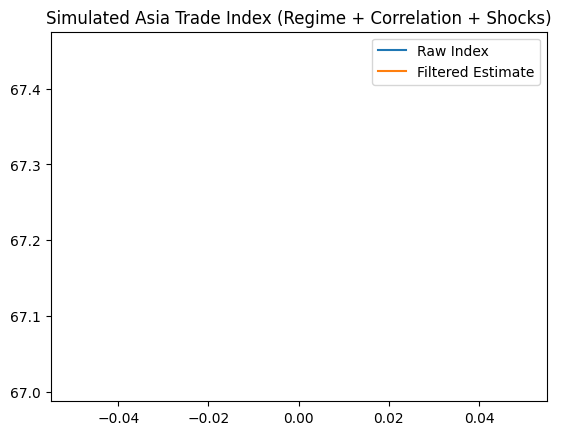

Tick 001 | Regime: RISK_ON  | Raw:   67.396 | Est:   67.018 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 002 | Regime: RISK_ON  | Raw:   67.612 | Est:   67.031 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 003 | Regime: RISK_ON  | Raw:   68.585 | Est:   67.065 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 004 | Regime: RISK_ON  | Raw:   68.957 | Est:   67.105 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 005 | Regime: RISK_ON  | Raw:   68.802 | Est:   67.142 | Buy 0.43 Hold 0.31 Sell 0.26
Tick 006 | Regime: RISK_ON  | Raw:   68.292 | Est:   67.167 | Buy 0.44 Hold 0.31 Sell 0.25
Tick 007 | Regime: RISK_ON  | Raw:   68.871 | Est:   67.204 | Buy 0.44 Hold 0.31 Sell 0.25
Tick 008 | Regime: RISK_ON  | Raw:   68.195 | Est:   67.225 | Buy 0.42 Hold 0.31 Sell 0.26
Tick 009 | Regime: RISK_ON  | Raw:   68.825 | Est:   67.260 | Buy 0.42 Hold 0.31 Sell 0.26
Tick 010 | Regime: RISK_ON  | Raw:   68.661 | Est:   67.290 | Buy 0.43 Hold 0.31 Sell 0.26
Tick 011 | Regime: RISK_ON  | Raw:   68.837 | Est:   67.323 | Buy 0.42 Hold 0.31 Sell 0.26

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
np.random.seed(7)

N_TICKS = 300          # simulation length
INTRADAY_VOL = 0.4     # base volatility
SHOCK_PROB = 0.03      # probability of volatility spike
REGIME_PROB = 0.02     # probability of regime change

alpha = 0.12           # smoothing
gain  = 0.18           # filter gain

# Weights for synthetic index
W = np.array([0.40, 0.25, 0.20, -0.15])  # equity, commodity, fx, risk

# Covariance matrix (key realism upgrade)
cov = np.array([
    [1.0,  0.65, 0.35, -0.45],
    [0.65, 1.0,  0.25, -0.30],
    [0.35, 0.25, 1.0,  -0.20],
    [-0.45,-0.30,-0.20, 1.0]
])

chol = np.linalg.cholesky(cov)

# -----------------------------
# Helper functions
# -----------------------------
def smooth(prev, current, alpha):
    return alpha * current + (1 - alpha) * prev

def filter_estimate(estimate, measurement, gain):
    return estimate + gain * (measurement - estimate)

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / e.sum()

# -----------------------------
# Initial state
# -----------------------------
state = np.array([100.0, 80.0, 50.0, 20.0])
estimate = W @ state

regime = "RISK_ON"

raw_series = []
est_series = []

# -----------------------------
# Live chart setup
# -----------------------------
plt.ion()
fig, ax = plt.subplots()

# -----------------------------
# Simulation loop
# -----------------------------
for t in range(N_TICKS):

    # ---- Regime shifts ----
    if np.random.rand() < REGIME_PROB:
        regime = "RISK_OFF" if regime == "RISK_ON" else "RISK_ON"

    if regime == "RISK_ON":
        drift = np.array([0.05, 0.03, 0.01, -0.04])
        vol_scale = 1.0
    else:
        drift = np.array([-0.06, -0.04, -0.02, 0.07])
        vol_scale = 1.4

    # ---- Shock events ----
    if np.random.rand() < SHOCK_PROB:
        shock = 3.5
    else:
        shock = 1.0

    # ---- Correlated shocks ----
    z = np.random.normal(size=4)
    correlated = chol @ z

    state = state + drift + correlated * INTRADAY_VOL * vol_scale * shock

    raw_index = W @ state

    # ---- Smoothing & filtering ----
    smoothed = smooth(estimate, raw_index, alpha)
    estimate = filter_estimate(estimate, smoothed, gain)

    raw_series.append(raw_index)
    est_series.append(estimate)

    # ---- Probabilistic signals ----
    if len(est_series) > 5:
        momentum = estimate - est_series[-5]
    else:
        momentum = 0.0

    logits = np.array([
        momentum * 2.0,          # Buy driver
        -abs(momentum) * 0.5,    # Hold driver
        -momentum * 2.0          # Sell driver
    ])

    probs = softmax(logits)

    buy_p, hold_p, sell_p = probs

    print(
        f"Tick {t:03d} | Regime: {regime:8s} "
        f"| Raw: {raw_index:8.3f} "
        f"| Est: {estimate:8.3f} "
        f"| Buy {buy_p:0.2f} Hold {hold_p:0.2f} Sell {sell_p:0.2f}"
    )

    # ---- Live chart update ----
    if t % 5 == 0:
        ax.clear()
        ax.plot(raw_series, label="Raw Index")
        ax.plot(est_series, label="Filtered Estimate")
        ax.legend()
        ax.set_title("Simulated Asia Trade Index (Regime + Correlation + Shocks)")
        plt.pause(0.01)

plt.ioff()
plt.show()

Tick 000 | RISK_ON  | Raw   67.80 | Est   67.02 | Buy 0.33 Hold 0.33 Sell 0.33


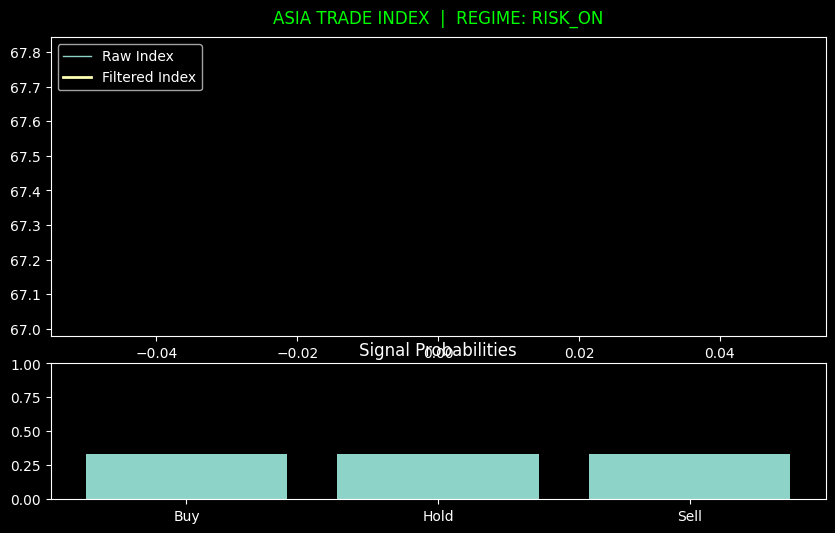

Tick 001 | RISK_ON  | Raw   67.91 | Est   67.04 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 002 | RISK_ON  | Raw   67.78 | Est   67.05 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 003 | RISK_ON  | Raw   68.03 | Est   67.08 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 004 | RISK_ON  | Raw   68.38 | Est   67.10 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 005 | RISK_ON  | Raw   68.33 | Est   67.13 | Buy 0.33 Hold 0.33 Sell 0.33
Tick 006 | RISK_ON  | Raw   68.55 | Est   67.16 | Buy 0.43 Hold 0.31 Sell 0.25
Tick 007 | RISK_ON  | Raw   68.28 | Est   67.19 | Buy 0.44 Hold 0.31 Sell 0.25
Tick 008 | RISK_ON  | Raw   68.41 | Est   67.21 | Buy 0.45 Hold 0.31 Sell 0.24
Tick 009 | RISK_ON  | Raw   68.77 | Est   67.25 | Buy 0.45 Hold 0.31 Sell 0.24
Tick 010 | RISK_ON  | Raw   68.82 | Est   67.28 | Buy 0.46 Hold 0.31 Sell 0.23
Tick 011 | RISK_ON  | Raw   68.97 | Est   67.32 | Buy 0.46 Hold 0.31 Sell 0.23
Tick 012 | RISK_ON  | Raw   68.92 | Est   67.35 | Buy 0.47 Hold 0.30 Sell 0.22
Tick 013 | RISK_ON  | Raw   68.70 | Est   67.38 | Bu

In [17]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)

N_TICKS = 250
INTRADAY_VOL = 0.35
SHOCK_PROB = 0.03
REGIME_PROB = 0.02

alpha = 0.10
gain  = 0.22

W = np.array([0.40, 0.25, 0.20, -0.15])

cov = np.array([
    [1.0,  0.60, 0.30, -0.40],
    [0.60, 1.0,  0.20, -0.25],
    [0.30, 0.20, 1.0,  -0.15],
    [-0.40,-0.25,-0.15, 1.0]
])

chol = np.linalg.cholesky(cov)

def smooth(prev, current, alpha):
    return alpha * current + (1 - alpha) * prev

def filter_estimate(est, meas, gain):
    return est + gain * (meas - est)

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / e.sum()

state = np.array([100.0, 80.0, 50.0, 20.0])
estimate = W @ state

regime = "RISK_ON"

raw_series = []
est_series = []

plt.style.use("dark_background")
plt.ion()

fig = plt.figure(figsize=(10, 6))
ax_main = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax_signal = plt.subplot2grid((3,1), (2,0))

for t in range(N_TICKS):

    # ---- Regime logic ----
    if np.random.rand() < REGIME_PROB:
        regime = "RISK_OFF" if regime == "RISK_ON" else "RISK_ON"

    if regime == "RISK_ON":
        drift = np.array([0.04, 0.02, 0.01, -0.03])
        vol_scale = 1.0
    else:
        drift = np.array([-0.05, -0.03, -0.01, 0.06])
        vol_scale = 1.5

    # ---- Shock events ----
    shock = 3.0 if np.random.rand() < SHOCK_PROB else 1.0

    # ---- Correlated movement ----
    z = np.random.normal(size=4)
    correlated = chol @ z

    state = state + drift + correlated * INTRADAY_VOL * vol_scale * shock

    raw_index = W @ state

    smoothed = smooth(estimate, raw_index, alpha)
    estimate = filter_estimate(estimate, smoothed, gain)

    raw_series.append(raw_index)
    est_series.append(estimate)

    # ---- Momentum → Probabilities ----
    if len(est_series) > 6:
        momentum = estimate - est_series[-6]
    else:
        momentum = 0.0

    logits = np.array([momentum * 2.2,
                       -abs(momentum) * 0.4,
                       -momentum * 2.2])

    probs = softmax(logits)

    buy_p, hold_p, sell_p = probs

    print(
        f"Tick {t:03d} | {regime:8s} "
        f"| Raw {raw_index:7.2f} "
        f"| Est {estimate:7.2f} "
        f"| Buy {buy_p:0.2f} Hold {hold_p:0.2f} Sell {sell_p:0.2f}"
    )

    # ---- Plotting ----
    if t % 3 == 0:

        ax_main.clear()
        ax_signal.clear()

        ax_main.plot(raw_series, linewidth=1.0, label="Raw Index")
        ax_main.plot(est_series, linewidth=2.0, label="Filtered Index")

        title_color = "lime" if regime == "RISK_ON" else "red"

        ax_main.set_title(
            f"ASIA TRADE INDEX  |  REGIME: {regime}",
            color=title_color,
            fontsize=12,
            pad=10
        )

        ax_main.legend(loc="upper left")

        ax_signal.bar(
            ["Buy", "Hold", "Sell"],
            [buy_p, hold_p, sell_p]
        )

        ax_signal.set_ylim(0, 1)
        ax_signal.set_title("Signal Probabilities")

        plt.pause(0.01)

plt.ioff()
plt.show()